In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random



from collections import Counter
from scipy.stats import mode

import sys
import os

# Add the directory containing 'aug.py' to the Python path
sys.path.append(os.path.abspath(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\day7to10_simclr_pred"))
from aug import one_Original,two_Ori_Hori_blur,three_Orig_Veri_sharp,four_Orig_verihori_sharp_blur,five_only_D10_Hori,six_only_D10_veri,seven_D10_verihori,ate_only_D7_Hori,nine_only_D7_veri,ten_D7_verihori,eleven_Orig_R90_sharp_blur,twelve_Orig_R270_sharp_blur,thirteen_Orig_HoriR90_sharp_blur,fourteen_Orig_HoriR270_sharp_blur,fifteen_D7_R90,sixteen_D7_R270,seventeen_D7_HoriR90,ateen_D7_HoriR270,ninteen_D10_R90,twenty_D10_R270,twentyone_D10_HoriR90,twentytwo_D10_HoriR270

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\SimCLR_base_models\ohnecontrast_balancedResize_simclr_modelepoch245.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_20228\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
from torchvision.transforms import Resize, RandomHorizontalFlip,RandomVerticalFlip
import random
import torchvision.transforms.functional as TF

In [24]:
#train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
#train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'

In [8]:
#train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day7'
#train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day10'

In [8]:
train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61'
train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61'

In [9]:
# Specify paths for both day7 and day10 folders



# Create the dataset
train_dataset = one_Original(train_day7_dir, train_day10_dir) 
batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

train_dataset = one_Original(train_day7_dir, train_day10_dir) 
train_dataset = two_Ori_Hori_blur(train_day7_dir, train_day10_dir) 
train_dataset = three_Orig_Veri_sharp(train_day7_dir, train_day10_dir) 
 train_dataset = four_Orig_verihori_sharp_blur(train_day7_dir, train_day10_dir) 
 train_dataset = five_only_D10_Hori(train_day7_dir, train_day10_dir) 
 train_dataset = six_only_D10_veri(train_day7_dir, train_day10_dir) 
train_dataset = seven_D10_verihori(train_day7_dir, train_day10_dir) 
 train_dataset = ate_only_D7_Hori(train_day7_dir, train_day10_dir) 
 train_dataset = nine_only_D7_veri(train_day7_dir, train_day10_dir) 
 train_dataset = ten_D7_verihori(train_day7_dir, train_day10_dir) 
 train_dataset = eleven_Orig_R90_sharp_blur(train_day7_dir, train_day10_dir) 
train_dataset = twelve_Orig_R270_sharp_blur(train_day7_dir, train_day10_dir) 
 train_dataset = thirteen_Orig_HoriR90_sharp_blur(train_day7_dir, train_day10_dir) 
 train_dataset = fourteen_Orig_HoriR270_sharp_blur(train_day7_dir, train_day10_dir)
 train_dataset = fifteen_D7_R90(train_day7_dir, train_day10_dir)
train_dataset = sixteen_D7_R270(train_day7_dir, train_day10_dir)
train_dataset = seventeen_D7_HoriR90(train_day7_dir, train_day10_dir)
 train_dataset = ateen_D7_HoriR270(train_day7_dir, train_day10_dir)
 train_dataset = ninteen_D10_R90(train_day7_dir, train_day10_dir)
 train_dataset = twenty_D10_R270(train_day7_dir, train_day10_dir)
 train_dataset = twentyone_D10_HoriR90(train_day7_dir, train_day10_dir)
train_dataset = twentytwo_D10_HoriR270(train_day7_dir, train_day10_dir)


In [10]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    
    for batch_day7_imgs, batch_day10_imgs in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats


In [14]:
import torch
from torch.utils.data import DataLoader

# Define dataset mappings
dataset_mapping = {
    "one": lambda: one_Original(train_day7_dir, train_day10_dir),
    "two": lambda: two_Ori_Hori_blur(train_day7_dir, train_day10_dir),
    "three": lambda: three_Orig_Veri_sharp(train_day7_dir, train_day10_dir),
    "four": lambda: four_Orig_verihori_sharp_blur(train_day7_dir, train_day10_dir),
    "five": lambda: five_only_D10_Hori(train_day7_dir, train_day10_dir),
    "six": lambda: six_only_D10_veri(train_day7_dir, train_day10_dir),
    "seven": lambda: seven_D10_verihori(train_day7_dir, train_day10_dir),
    "eight": lambda: ate_only_D7_Hori(train_day7_dir, train_day10_dir),
    "nine": lambda: nine_only_D7_veri(train_day7_dir, train_day10_dir),
    "ten": lambda: ten_D7_verihori(train_day7_dir, train_day10_dir),
    "eleven": lambda: eleven_Orig_R90_sharp_blur(train_day7_dir, train_day10_dir),
    "twelve": lambda: twelve_Orig_R270_sharp_blur(train_day7_dir, train_day10_dir),
    "thirteen": lambda: thirteen_Orig_HoriR90_sharp_blur(train_day7_dir, train_day10_dir),
    "fourteen": lambda: fourteen_Orig_HoriR270_sharp_blur(train_day7_dir, train_day10_dir),
    "fifteen": lambda: fifteen_D7_R90(train_day7_dir, train_day10_dir),
    "sixteen": lambda: sixteen_D7_R270(train_day7_dir, train_day10_dir),
    "seventeen": lambda: seventeen_D7_HoriR90(train_day7_dir, train_day10_dir),
    "eighteen": lambda: ateen_D7_HoriR270(train_day7_dir, train_day10_dir),
    "nineteen": lambda: ninteen_D10_R90(train_day7_dir, train_day10_dir),
    "twenty": lambda: twenty_D10_R270(train_day7_dir, train_day10_dir),
    "twentyone": lambda: twentyone_D10_HoriR90(train_day7_dir, train_day10_dir),
    "twentytwo": lambda: twentytwo_D10_HoriR270(train_day7_dir, train_day10_dir),
}

# Define batch size
batch_size = 16

# Function to extract and concatenate features
import os
#def extract_and_combine_features(simclr_model, dataset_mapping, save_path="features"):
def extract_and_combine_features(simclr_model, dataset_mapping):
    # Check if the directory exists, and create it if not
    #if not os.path.exists(save_path):
        #print(f"Creating directory: {save_path}")
        #os.makedirs(save_path)

    day7_features = []
    day10_features = []

    for key, dataset_func in dataset_mapping.items():
        # Load dataset
        train_dataset = dataset_func()

        # Define DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

        # Extract features
        cond7_feats, cond10_feats = prepare_data_features(simclr_model, train_loader)

        # Save individual features
        #cond7_path = f"{save_path}/cond7_{key}.pt"
        #cond10_path = f"{save_path}/cond10_{key}.pt"
        #print(f"Saving Day 7 features to: {cond7_path}")
        #print(f"Saving Day 10 features to: {cond10_path}")
        #torch.save(cond7_feats, cond7_path)
        #torch.save(cond10_feats, cond10_path)

        # Append to the list for concatenation
        day7_features.append(cond7_feats)
        day10_features.append(cond10_feats)

    # Concatenate all day 7 and day 10 features
    combined_cond7 = torch.cat(day7_features, dim=0)
    combined_cond10 = torch.cat(day10_features, dim=0)

    # Save combined features
    #combined_cond7_path = f"{save_path}/combined_cond7.pt"
    #combined_cond10_path = f"{save_path}/combined_cond10.pt"
    #print(f"Saving combined Day 7 features to: {combined_cond7_path}")
    #print(f"Saving combined Day 10 features to: {combined_cond10_path}")
    #torch.save(combined_cond7, combined_cond7_path)
    #torch.save(combined_cond10, combined_cond10_path)

    return combined_cond7, combined_cond10


In [15]:
#combined_ex7, combined_ex10 = extract_and_combine_features(simclr_model, dataset_mapping, save_path="features")
combined_ex7, combined_ex10 = extract_and_combine_features(simclr_model, dataset_mapping)

 33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])
Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


 33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


In [17]:
combined_ex7.shape

torch.Size([836, 512])

In [20]:
torch.save(combined_ex7, "combined_ex7.pt")


In [21]:
torch.save(combined_ex10, "combined_ex10.pt")


In [23]:
combined_ex7 = torch.load("combined_ex7.pt")
combined_ex7.shape

C:\Users\k54739\AppData\Local\Temp\ipykernel_2260\2465215611.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_ex7 = torch.load("combined_ex7.pt")


torch.Size([836, 512])

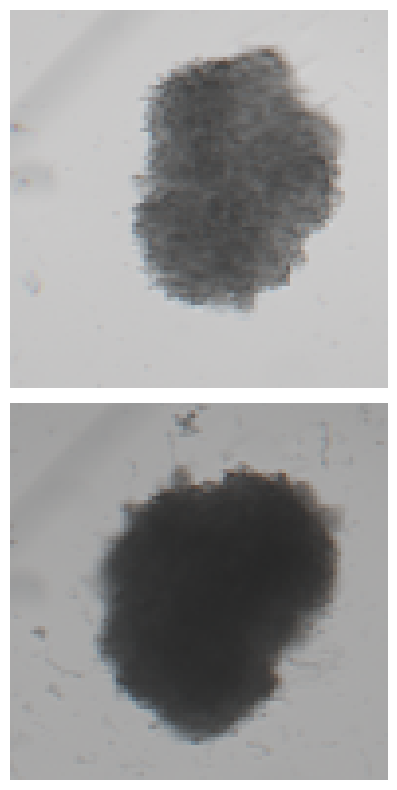

In [10]:
# Retrieve one dataset sample
#day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]
day7_img, day10_img= train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
#plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
#plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


In [11]:
# Extract features from the training dataset
sd7, sd10 = prepare_data_features(simclr_model, train_loader)

 50%|█████     | 1/2 [00:01<00:01,  1.76s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

Day 7 Batch features shape: torch.Size([13, 512])
Day 10 Batch features shape: torch.Size([13, 512])
Day 7 Features shape after concatenation: torch.Size([29, 512])
Day 10 Features shape after concatenation: torch.Size([29, 512])


In [12]:
# Save training features in the "features" subfolder
torch.save(sd7, "sd7.pt")
torch.save(sd10, "sd10.pt")

# Save training features
#torch.save(exploded38_day7, 'features\ex7.pt')
#torch.save(exploded38_day10, 'features\ex10.pt')

In [27]:
# Extract features from the training dataset
cond7, cond10 = prepare_data_features(simclr_model, train_loader)

 11%|█         | 1/9 [00:01<00:12,  1.54s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:03<00:10,  1.50s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:09,  1.54s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:06<00:07,  1.56s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:06,  1.58s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:09<00:04,  1.60s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:11<00:03,  1.64s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:12<00:00,  1.16s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])
Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])


100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [28]:
# Save training features in the "features" subfolder
torch.save(cond7,  "cond7.pt")
torch.save(cond10,"cond10.pt")